# 🧠 Rock Paper Scissors Classification with MobileNetV2

This notebook demonstrates training a transfer learning model using MobileNetV2 on the Rock-Paper-Scissors dataset from Hugging Face. It includes data preprocessing, augmentation, class balancing, and fine-tuning to avoid overfitting.

## 1. Install and Import Libraries

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


## 2. Extract Dataset from Hugging Face

In [ ]:

dataset = load_dataset("Javtor/rock-paper-scissors")
label_names = dataset['train'].features['label'].names

base_dir = "dataset"
splits = ['train', 'test']

def save_images_to_folder(split_name):
    split_dataset = dataset[split_name]
    for idx, sample in enumerate(split_dataset):
        label = label_names[sample['label']]
        image = sample['image']
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        save_dir = os.path.join(base_dir, split_name, label)
        os.makedirs(save_dir, exist_ok=True)
        image_path = os.path.join(save_dir, f"{split_name}_{label}_{idx}.jpg")
        image.save(image_path)

for split in splits:
    save_images_to_folder(split)

print("✅ Dataset saved in dataset/train and dataset/test.")


## 3. Load Dataset with Augmentation

In [2]:

train_dir = 'dataset/train'
test_dir = 'dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)


Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## 4. Compute Class Weights

In [3]:

y_train = train_gen.classes
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


## 5. Define Model Architecture (Transfer Learning with Dropout)

In [4]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


## 6. Train Top Layers

In [5]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


c:\Users\shailshree\Desktop\Academics\3rd year\computervision\coursework\app\rock_paper_scissor_game_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7279 - loss: 0.5993

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 757ms/step - accuracy: 0.7299 - loss: 0.5954 - val_accuracy: 0.9067 - val_loss: 0.2967 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9422 - loss: 0.1361

63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 749ms/step - accuracy: 0.9423 - loss: 0.1362 - val_accuracy: 0.9345 - val_loss: 0.1878 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 788ms/step - accuracy: 0.9624 - loss: 0.1031 - val_accuracy: 0.8929 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 756ms/step - accuracy: 0.9808 - loss: 0.0624 - val_accuracy: 0.8869 - val_loss: 0.4487 - learning_rate: 5.0000e-04


## 7. Fine-Tune Last 20 Layers

In [6]:

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8863 - loss: 0.3017

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 824ms/step - accuracy: 0.8868 - loss: 0.3003 - val_accuracy: 0.9405 - val_loss: 0.2225 - learning_rate: 1.0000e-05
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 790ms/step - accuracy: 0.9674 - loss: 0.1045 - val_accuracy: 0.9325 - val_loss: 0.2217 - learning_rate: 1.0000e-05
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 784ms/step - accuracy: 0.9623 - loss: 0.0979 - val_accuracy: 0.9206 - val_loss: 0.2584 - learning_rate: 1.0000e-05
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 784ms/step - accuracy: 0.9690 - loss: 0.0830 - val_accuracy: 0.9325 - val_loss: 0.2387 - learning_rate: 5.0000e-06


## 8. Plot Accuracy and Loss (Smoothed)

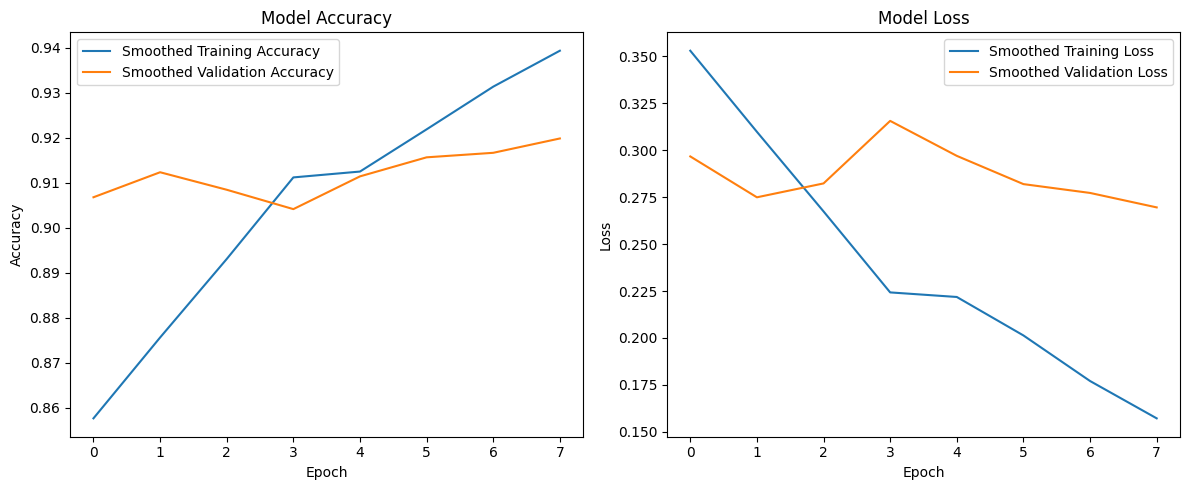

In [7]:

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def combine_history(h1, h2):
    combined = {}
    for k in h1.history:
        combined[k] = h1.history[k] + h2.history.get(k, [])
    return combined

full_history = combine_history(history, fine_tune_history)

smooth_acc = smooth_curve(full_history['accuracy'])
smooth_val_acc = smooth_curve(full_history['val_accuracy'])
smooth_loss = smooth_curve(full_history['loss'])
smooth_val_loss = smooth_curve(full_history['val_loss'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smooth_acc, label='Smoothed Training Accuracy')
plt.plot(smooth_val_acc, label='Smoothed Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smooth_loss, label='Smoothed Training Loss')
plt.plot(smooth_val_loss, label='Smoothed Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 9. Evaluate Model on Test Set

In [8]:

# Evaluate the trained model on the unseen test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 561ms/step - accuracy: 0.8926 - loss: 0.3363
✅ Test Accuracy: 0.8871


## 10. Classification Report and Confusion Matrix

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step
              precision    recall  f1-score   support

       paper       0.37      0.24      0.29       124
        rock       0.35      0.47      0.40       124
    scissors       0.31      0.31      0.31       124

    accuracy                           0.34       372
   macro avg       0.34      0.34      0.34       372
weighted avg       0.34      0.34      0.34       372



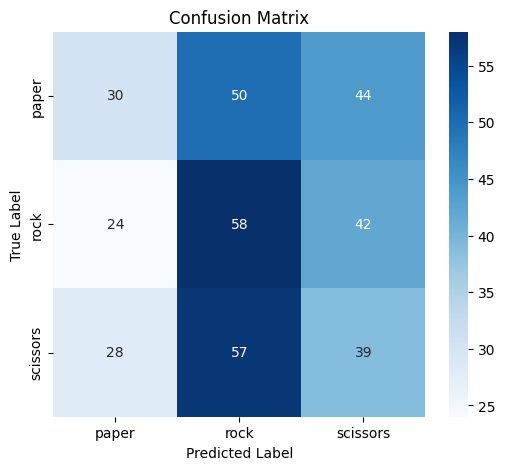

In [12]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Predict labels
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


## 11. Export Model to `.h5` and `.tflite`

In [13]:

# Save as HDF5 format
model.save("rock_paper_scissors_model.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("rock_paper_scissors_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model exported as .h5 and .tflite")


INFO:tensorflow:Assets written to: C:\Users\SHAILS~1\AppData\Local\Temp\tmpggdkqgzg\assets


INFO:tensorflow:Assets written to: C:\Users\SHAILS~1\AppData\Local\Temp\tmpggdkqgzg\assets


Saved artifact at 'C:\Users\SHAILS~1\AppData\Local\Temp\tmpggdkqgzg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  3071833244880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833245456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833247184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833246800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833244688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833247376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833246416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833245072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833247568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3071833245648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  30